In [1]:
import pandas as pd
import numpy as np
import torch

from matplotlib import pyplot as plt 

import time

In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms, utils
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
import torchvision

import os
import copy

from skimage import io, transform

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   

/home/ghostoftime111/anaconda3/envs/DL/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ghostoftime111/anaconda3/envs/DL/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
from pydub import AudioSegment
from pydub.playback import play
import librosa

In [4]:
print(torchvision.__version__)

0.13.1a0


In [5]:
torch.cuda.is_available()

True

## preparing dataloader

In [6]:
data_dir = "/mnt/g/onlinelessons/Multimedia/HW/project/dataset/final_data/"

class audio_custom_dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the audios.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.audio_csv = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.audio_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_name = self.audio_csv.iloc[idx, 1]
        waveform, sample_rate = torchaudio.load(audio_name)
        transform = T.MFCC(
            sample_rate=sample_rate,
            n_mfcc=31,
            melkwargs={"n_fft": 2048  , "hop_length": 512 , "n_mels": 128, "center": False}
        )
        waveform = transform(waveform)
        
        waveform = nn.functional.normalize(waveform, dim=-1)
        
        
        label = self.audio_csv.iloc[idx, 3:7]
        label = np.array(label, dtype=np.float16)
        
       # sample = {'audio': waveform, 'label': label}
        sample = [torch.flatten(waveform), label]

        if self.transform:
            sample = self.transform(sample)

        return sample

In [7]:
audio_dataset = audio_custom_dataset(csv_file='./dataset/final_data/train_data_encoded.csv')

In [8]:
audio_dataset

In [9]:
str(torchaudio.get_audio_backend())

'sox_io'

## loading datas in batches

In [11]:
def collate_fn(batch):
    return [
      torch.stack([x[0] for x in batch]),
      torch.tensor([x[1] for x in batch])
      #torch.stack([x[audio] for x in batch]),
      #torch.tensor([x[labels] for x in batch])
        ]

In [12]:
audio_datasets = {x.split("_")[0]: audio_custom_dataset(os.path.join(data_dir, x))
                      for x in ["train_data_encoded.csv", "test_data_encoded.csv", "val_data_encoded.csv"]}
dataloaders = {x: torch.utils.data.DataLoader(audio_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=8, collate_fn=collate_fn)
                      for x in ["train", "test", "val"]}
dataset_sizes = {x: len(audio_datasets[x]) for x in ["train", "test", "val"]}
#class_names = audio_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## data visualization

In [13]:
train_set = audio_datasets['train']
train_set[6]

[tensor([-0.2386, -0.1726, -0.1243,  ..., -0.1263, -0.1273, -0.0714]),
 array([1., 0., 0., 0.], dtype=float16)]

In [14]:
ss = train_set[1][0].shape
ss

torch.Size([2790])

In [15]:
count = 0
for j, i in enumerate(range(len(train_set))):
    if train_set[i][0].shape == ss:
        continue
    else:
        count +=1
        print(f"index {j} shape is: {train_set[i][0].shape}")
        
        
print(f"count is : {count}")

count is : 0


In [16]:
dataloaders["train"]

In [17]:
input_s, classes = next(iter(dataloaders['train']))

In [18]:
input_s[0]

tensor([-0.1473, -0.1287, -0.1213,  ..., -0.1136, -0.0614, -0.0820])

In [19]:
classes[0]

tensor([1., 0., 0., 0.], dtype=torch.float16)

In [20]:
flat = input_s[2].shape[0]
print(f"input shape is :{input_s[2].shape}\nlebel shape is: {classes[0].shape}")

input shape is :torch.Size([2790])
lebel shape is: torch.Size([4])


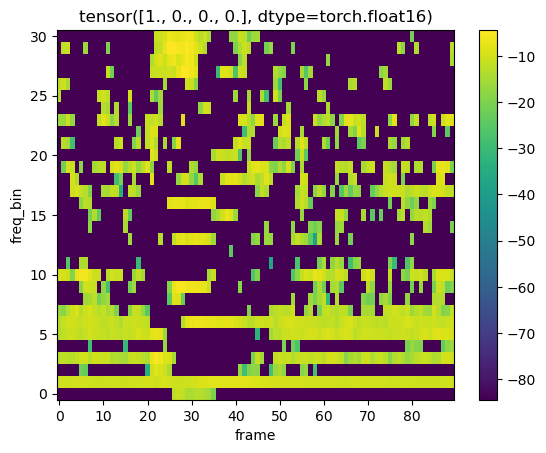

In [21]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
plot_spectrogram(input_s[0].reshape(31, 90), f"{classes[0]}")
    


## training function

In [28]:
accuracies_train = []
accuracies_val = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    l1_lambda = 0.001
    counter = 0
    patience = 15
    flag = 0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        if flag:
            break
        
        print('-' * 50)
        print('\033[31m' + f'Epoch {epoch + 1}/{num_epochs}' + '\033[0m')
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print('\033[32m' + f'phase: {phase}' + '\033[0m')
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                model.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = outputs
                    loss = criterion(preds, labels)
                    
                            # Compute L1 regularization loss
                    l1_loss = 0
                    for param in model.parameters():
                        l1_loss += torch.norm(param, 2)

                    # Add L2 regularization to the total loss
                    loss += l1_lambda * l1_loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                # print(preds)
                running_loss += loss.item() * inputs.size(0)
                chosen_label = torch.argmax(labels, dim=1)
                predicted_value = torch.argmax(preds, dim=1)
                # print("batch labels:")
                # print('\033[34m' + f"{chosen_label}" + '\033[0m')
                # print("pred labels:")
                # print('\033[34m' + f"{predicted_value}" + '\033[0m')
                # print("-" * 10)
                
                running_corrects += torch.sum(chosen_label == predicted_value)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val':
                accuracies_val.append(epoch_acc)
                
            else:
                accuracies_train.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                counter = 0
                print(counter)
            elif phase == 'val':
                counter = counter + 1
                print(counter)
                
            if counter >= patience:
                print("Early stopping after {} epochs".format(epoch))
                flag = 1
                break

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## preparing model

In [35]:
class MLP_Audio_Model(torch.nn.Module):

    def __init__(self):
        super(MLP_Audio_Model3, self).__init__()


        self.linear1 = torch.nn.Linear(2790, 512)
        self.bachNoem1 = nn.BatchNorm1d(512)
        self.activation1 = torch.nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        # self.linear2 = torch.nn.Linear(1024, 512)
        # self.bachNoem2 = nn.BatchNorm1d(512)
        # self.activation2 = torch.nn.ReLU()
        # self.dropout2 = nn.Dropout(p=0.5)

        self.linear3 = torch.nn.Linear(512, 128)
        self.bachNoem3 = torch.nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(p=0.5)
        self.activation3 = torch.nn.ReLU()

#         self.linear4 = torch.nn.Linear(256, 128)
#         self.bachNoem4 = torch.nn.BatchNorm1d(128)
#         self.dropout4 = nn.Dropout(p=0.3)
#         self.activation4 = torch.nn.ReLU()
        
        self.linear6 = torch.nn.Linear(128, 64)
        self.bachNoem6 = torch.nn.BatchNorm1d(64)
        self.dropout6 = nn.Dropout(p=0.5)
        self.activation6 = torch.nn.ReLU()
        
        # self.linear7 = torch.nn.Linear(64, 32)
        # self.bachNoem7 = torch.nn.BatchNorm1d(32)
        # self.dropout7 = nn.Dropout(p=0.5)
        # self.activation7 = torch.nn.ReLU()
        
        self.linear8 = torch.nn.Linear(64, 16)
        self.bachNoem8 = torch.nn.BatchNorm1d(16)
        self.dropout8 = nn.Dropout(p=0.5)
        self.activation8 = torch.nn.ReLU()
        
#         self.linear9 = torch.nn.Linear(32, 16)
#         self.bachNoem9 = torch.nn.BatchNorm1d(16)
#         self.dropout9 = nn.Dropout(p=0.2)
#         self.activation9 = torch.nn.ReLU()

        self.linear5 = torch.nn.Linear(16, 4)

        self.softmax = torch.nn.Softmax(dim = 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bachNoem1(x)
        x = self.activation1(x)
        x = self.dropout1(x)

        # x = self.linear2(x)
        # x = self.bachNoem2(x)
        # x = self.activation2(x)
        # x = self.dropout2(x)

        x = self.linear3(x)
        x = self.bachNoem3(x)
        x = self.activation3(x)
        x = self.dropout3(x)

        # x = self.linear4(x)
        # x = self.bachNoem4(x)
        # x = self.activation4(x)
        # x = self.dropout4(x)

        x = self.linear6(x)
        x = self.bachNoem6(x)
        x = self.activation6(x)
        x = self.dropout6(x)
        
        # x = self.linear7(x)
        # x = self.bachNoem7(x)
        # x = self.activation7(x)
        # x = self.dropout7(x)
        
        x = self.linear8(x)
        x = self.bachNoem8(x)
        x = self.activation8(x)
        x = self.dropout8(x)   
        
        
        x = self.linear5(x)

        x = self.softmax(x)
        return x

MLP_model = MLP_Audio_Model3()

print('The model:')
print(MLP_model)

# print('\n\nModel params:')
# for param in MLP_model.parameters():
#     print(param)

The model:
MLP_Audio_Model3(
  (linear1): Linear(in_features=2790, out_features=512, bias=True)
  (bachNoem1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (bachNoem3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (activation3): ReLU()
  (linear6): Linear(in_features=128, out_features=64, bias=True)
  (bachNoem6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout6): Dropout(p=0.5, inplace=False)
  (activation6): ReLU()
  (linear8): Linear(in_features=64, out_features=16, bias=True)
  (bachNoem8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout8): Dropout(p=0.5, inplace=False)
  (activation8): ReLU()
  (linear5): Linear(in_features=16, out_features=4, bia

## training proccess

In [36]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(MLP_model.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

num_epochs = 300

MLP_model = train_model(MLP_model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

--------------------------------------------------
Epoch 1/300
phase: train
train Loss: 1.4701 Acc: 0.2329
phase: val
val Loss: 1.4547 Acc: 0.2840
0

--------------------------------------------------
Epoch 2/300
phase: train
train Loss: 1.4670 Acc: 0.2566
phase: val
val Loss: 1.4489 Acc: 0.3086
0

--------------------------------------------------
Epoch 3/300
phase: train
train Loss: 1.4499 Acc: 0.3120
phase: val
val Loss: 1.4243 Acc: 0.4568
0

--------------------------------------------------
Epoch 4/300
phase: train
train Loss: 1.4366 Acc: 0.3638
phase: val
val Loss: 1.3801 Acc: 0.5802
0

--------------------------------------------------
Epoch 5/300
phase: train
train Loss: 1.3978 Acc: 0.4262
phase: val
val Loss: 1.3507 Acc: 0.5926
0

--------------------------------------------------
Epoch 6/300
phase: train
train Loss: 1.3532 Acc: 0.4947
phase: val
val Loss: 1.2860 Acc: 0.6481
0

--------------------------------------------------
Epoch 7/300
phase: train
train Loss: 1.3102 Acc: 

## accuracy visualization

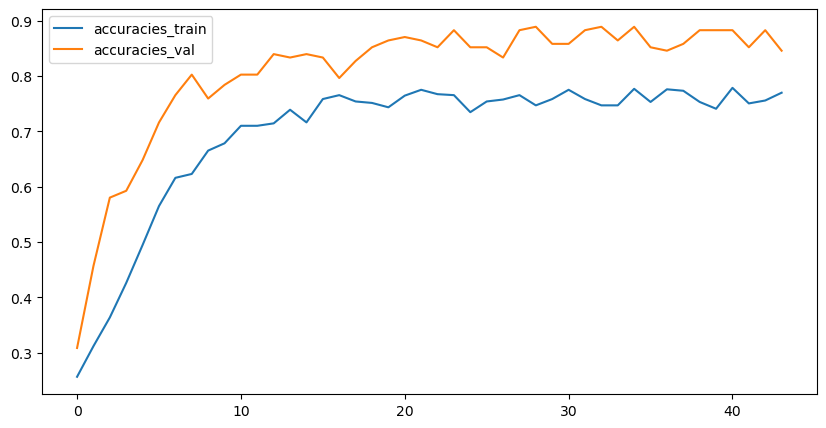

In [50]:
def ToCPU(in_tensor):
    return in_tensor.to("cpu")

def learnin_graph(acc_train, acc_val, epochs): 
    x = list(range(epochs))
    fig, ax = plt.subplots(figsize=(10, 5))
    # print(f"acc_train :{acc_train}")
    # print(f"acc_val :{acc_val}")
    ax.plot(x, acc_train, label='accuracies_train')
    ax.plot(x, acc_val, label='accuracies_val')
    ax.legend()
    plt.show()

learnin_graph(list(map(ToCPU, accuracies_train)), list(map(ToCPU, accuracies_val)),62)

## saving best model

In [39]:
best_val = max(accuracies_val)
path_to_model = "MLP_" + f"{best_val:6f}" + "new_model3.pt"
torch.save(MLP_model, path_to_model)

In [40]:
from sklearn.metrics import confusion_matrix

## visualizing test results

In [41]:

def visualize_model(model):
    true_labels = []
    predicted_labels = []
        
    was_training = model.training
    model.eval()
    correct = 0
    total = 0
    running_corrects = 0
    
    fig = plt.figure()
    model = model.to(device)

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            preds = outputs

            chosen_label = torch.argmax(labels, dim=1)
            print('\033[30m' + f'label:     {chosen_label}' + '\033[0m')
            
            predicted_value = torch.argmax(preds, dim=1)
            print('\033[31m' + f'predicted: {predicted_value}' + '\033[0m')
            
            print('\033[33m' + f'predicted: {preds}' + '\033[0m')
            
            running_corrects = torch.sum(chosen_label == predicted_value)         
            correct = correct + running_corrects
            print('\033[32m' + f'corrects:: {correct}' + '\033[0m')
            
            total = total + inputs.size(0)
            print('\033[34m' + f'total: {total}' + '\033[0m')
            
            true_labels.extend(chosen_label.to("cpu").numpy())
            predicted_labels.extend(predicted_value.to("cpu").numpy())
            
            
        accuracy = 100 * correct / total
        print('\033[35m' + f'acuuracy: {accuracy}' + '\033[0m')   
            
        model.train(mode=was_training)
        
        
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.imshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [42]:
for model_dir in os.listdir("./"):
    if model_dir.split(".")[-1] != "pt":
        continue
    print(model_dir)   
        



best.pt
CNN_0.962963.pt
MLP_0.761364.pt
MLP_0.851064.pt
MLP_0.872340.pt
MLP_0.888889new_model3.pt
MLP_0.893617.pt
MLP_0.914894.pt
MLP_0.919753.pt
MLP_0.919753new_model2.pt
MLP_0.932099new_model3.pt
MLP_0.936170.pt
MLP_0.936170_best.pt
MLP_0.936170_old.pt
MLP_0.938272new_model3.pt


## loading desired model

In [44]:
current_dir = os.getcwd()
model_path = current_dir + '/' + "MLP_0.888889new_model3.pt"

test_model = MLP_Audio_Model3()
test_model = torch.load(model_path)

## test results and confusion matrix

label:     tensor([2, 2, 3, 1, 3, 2, 0, 0], device='cuda:0')
predicted: tensor([2, 2, 3, 3, 0, 2, 0, 0], device='cuda:0')
predicted: tensor([[0.0014, 0.0050, 0.9922, 0.0014],
        [0.0078, 0.0188, 0.9677, 0.0058],
        [0.0517, 0.0121, 0.0337, 0.9025],
        [0.2243, 0.1543, 0.1150, 0.5064],
        [0.4971, 0.0635, 0.1145, 0.3249],
        [0.0348, 0.1224, 0.8232, 0.0196],
        [0.9740, 0.0049, 0.0091, 0.0120],
        [0.7720, 0.0512, 0.1003, 0.0765]], device='cuda:0')
corrects:: 6
total: 8
label:     tensor([2, 3, 3, 0, 1, 0, 0, 2], device='cuda:0')
predicted: tensor([2, 3, 3, 0, 1, 0, 0, 2], device='cuda:0')
predicted: tensor([[2.2302e-02, 1.4498e-01, 8.1981e-01, 1.2903e-02],
        [1.1154e-01, 7.9129e-02, 5.4613e-02, 7.5472e-01],
        [1.1969e-02, 1.7278e-03, 5.4074e-03, 9.8090e-01],
        [9.3660e-01, 1.3064e-02, 1.8175e-02, 3.2157e-02],
        [4.5373e-04, 9.9293e-01, 6.3919e-03, 2.2013e-04],
        [8.6471e-01, 3.8454e-02, 4.7756e-02, 4.9080e-02],
        [8

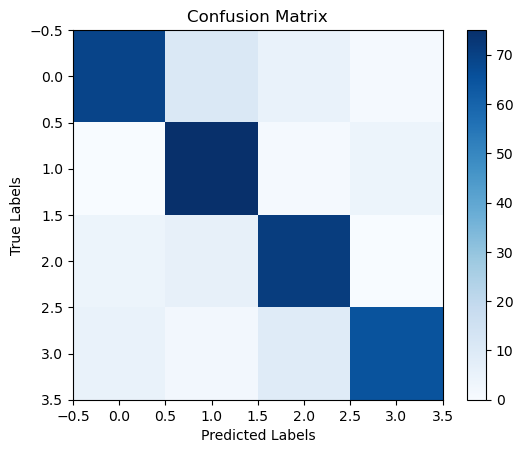

In [45]:
visualize_model(test_model)